<a href="https://colab.research.google.com/github/godblessourdeadkotatsu/lecture-notes-2024-25/blob/main/NNDL/LabCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Convolutional Neural Networks** (CNNs)

Here is the translated version with updated links:

---

**Convolutional Neural Networks (CNNs)** are a type of artificial neural network designed for the efficient processing of data in matrix (or tensor) form, with images being the most common example.

These networks have revolutionized the field of image processing and have driven the widespread adoption of deep learning. In many areas, including image analysis, pattern recognition, and computer vision, deep learning  represents the state of the art since 10 years.

CNNs use **convolutional layers**  to extract features, along with fully connected layers, to solve the task at hand (in our case, *multi-class classification*).

![Image](https://mriquestions.com/uploads/3/4/5/7/34572113/cnn-sample-layout_orig.png)





#<font color='lime'><u>**Lab: FashionMNIST Classification with CNN**</u></font>

We will use [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist), a dataset containing low-resolution images of clothing items, provided by Zalando for classification. It is designed as a more challenging benchmark than [MNIST](https://en.wikipedia.org/wiki/MNIST_database), a well-known dataset containing a large set of images of handwritten digits.

For the deep learning framework, we will use **PyTorch**.



### <font color='gold'>**Installing Dependencies and Importing Libraries**</font>

Let's install the dependencies and import the necessary libraries.




In [ ]:
%%capture
!pip install umap-learn torchviz torchview

In [ ]:
%%capture

# for data visualisation
from sklearn.decomposition import PCA
from umap import UMAP

# for graphs visualisation
import matplotlib.pyplot as plt

# PyTorch components
import torchvision
from torchvision import datasets
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

# varia
import numpy as np
from tqdm import tqdm
from types import SimpleNamespace
from torchviz import make_dot
from torchview import draw_graph
from sklearn.metrics import ConfusionMatrixDisplay

### <font color='gold'>**Dataset Creation**</font>

PyTorch provides the `FashionMNIST` (`torchvision.datasets`) which encapsulates the dataset as a list of [PIL images](https://pillow.readthedocs.io/en/latest/reference/Image.html). To convert them into tensors, it is sufficient to specify the use of the transformation `torchvision.ToTensor`.


In [ ]:
#FashionMNIST, as most Pytorch datasets, contains two main components: Data and Targets
dataset = FashionMNIST(
    root='data',  # directory  download
    download=True,
    transform=ToTensor()  # transformation: PIL.image ==> torch.Tensor PIL= Python Imaging Library
    )
target_names =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\n Dataset Information\n' + '-'*100)
print(f'Number of di examples: {len(dataset):,}')
print('Number of classes:', len(set(dataset.targets.tolist())))
print('Target Names:',target_names)
print('Data shape:',dataset.data.shape)
print('Targets shape:',dataset.targets.shape)


### <font color='gold'>**Let's Visualize a first example of the Dataset
**</font>


We can use the `matplotlib.pyplot.imshow` function to visualize the tensors as images. The function maps each value (normalized to the range [0, 1]) to a color. In this case, we invert the value to have black images on a white background.


In [ ]:
display(dataset)
# Create a DataLoader to iterate through the dataset #DataLoader allows to batch, shuffle, parallel
data_loader = DataLoader(dataset, batch_size=10, shuffle=True)

# Get a single batch of images and labels
data_iter = iter(data_loader)
images, labels = next(data_iter)

print(f"Images shape (Batch): {images.shape}") # 4 dimensions, 1st for batch size
print(f"Labels (Batch): {labels}")

# Function to show an image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms

# Define transformation: convert images to tensors
transform = transforms.Compose([transforms.ToTensor()])

# Load the FashionMNIST dataset
fashion_mnist = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
# Get a single image and its label
image, label = fashion_mnist[10]

# Convert the image to a NumPy array and remove extra dimensions
image = image.squeeze().numpy()

# Define label names for FashionMNIST (optional, for better understanding)
labels_map = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Display the image using matplotlib
plt.figure(figsize=(1, 1))
plt.imshow(image, cmap='gray')

plt.title(f"Label: {labels_map[label]}")
plt.axis('off')
plt.show()



### <font color='gold'>**Partitioning the Dataset: Train, Validation, Test**</font>

Using the `torch.utils.data.random_split` function, we randomly divide the dataset into 3 portions:

- <u>Training Set</u>  (80%): Contains the data that will be used to train the network.
- <u>Test Set</u>  (10%): Contains the data that will be used **only at the end** to test the network's performance.
- <u>Validation set</u> (10%): Contains the data that will be used periodically during training to estimate the performance of the network on the test set.
➡️ **Note**: The data in the validation set is not used to train the network.


In [ ]:
seed_random_split = 2023

random_generator = torch.Generator().manual_seed(seed_random_split)
train_dataset, val_dataset, test_dataset = random_split(dataset, lengths=[0.8, 0.1, 0.1], generator=random_generator)

print('Random split dataset\n' + '-'*100)
print(f'Training set:\t{len(train_dataset):,}')
print(f'Validation set:\t{len(val_dataset):,}')
print(f'Test set:\t{len(test_dataset):,}')

###   <font color='gold'>**Let's Observe Some Information About an Example from the Training Set**</font>

We can see that an example is a 3-dimensional tensor, referring respectively to:


1. Number of Channels:
   - RGB images will have 3 channels.
   - RGBA images (A = alpha, opacity) will have 4 channels.
   - Grayscale images (our case) will have 1 channel.
2. Image Height
3. Image Width

In [ ]:
print('Example n. 1\n' + '-'*100)
x, y = train_dataset[0]
print('Input:', x.shape, '\t ==> (channel, height, width)')
print('Classe:', y, f'({target_names[y]})')


### <font color='gold'>**Let's Visualize Some Examples (Images)**</font>

We can use the `matplotlib.pyplot.imshow` function to visualize the tensors as images. The function maps each value (normalized to the range [0, 1]) to a color. In this case, we invert the value to have black images on a white background.


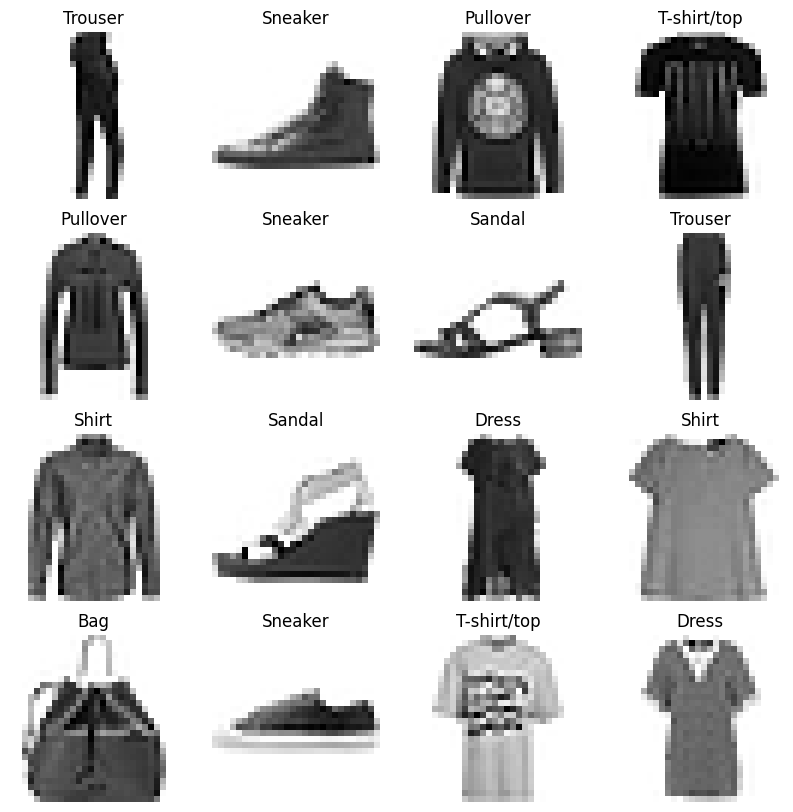

In [ ]:
plt.subplots(4,4, figsize=(10,10))
for i in range(16):
  x, y = train_dataset[i]
  plt.subplot(4, 4, i+1)
  plt.imshow(1-x[0], cmap='gray')
  plt.title(target_names[y])
  plt.axis('off')


### <font color='gold'>**Let's Visualize the Distribution of Examples ( Dimensionality Reduction)**</font>

When tackling a task, it's good practice to carefully observe the dataset first.

We can visualize how separated the classes are by projecting the tensors of the examples into a two-dimensional space and displaying them in a *scatter plot*.

We can reduce the tensors corresponding to the examples into pairs of real numbers using a *dimensionality reduction* approach.

Let's Define a *Utility Function* to Visualize the Dataset Using a Given Dimensionality Reduction Method (Compatible with the `Scikit-Learn` Interface)


In [ ]:
def plot_dataset_visualization(X, y, method, title):
  X_transformed = method.fit_transform(X)

  plt.figure(figsize=(8,8))
  for i, l in enumerate(target_names):
    X_plot = X_transformed[y == i]
    plt.scatter(X_plot[:,0], X_plot[:,1], label=l, c=f'C{i}', s=1)

  plt.legend(markerscale=8, loc=(1.01,0), frameon=False)
  plt.title(title)

Let's Visualize the Dataset, Coloring Examples of the Same Class with the Same Color, Using [Principal Component Analisys](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA): PCA performs a linear transformation of the dataset into a space of new, uncorrelated features. Subsequently, the *n* (2 in our case) features that capture the maximum variance are retained.



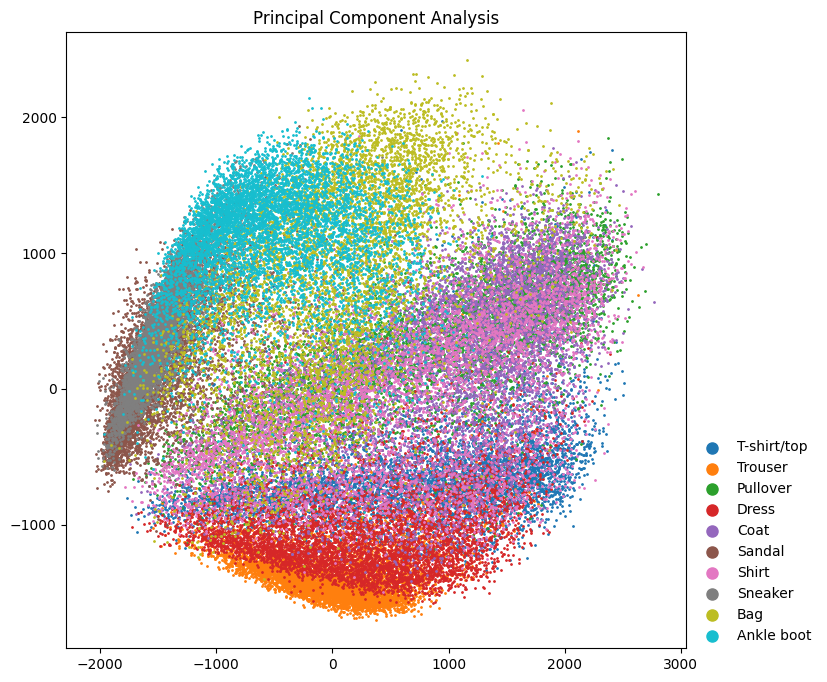

In [ ]:
X = dataset.data
y = dataset.targets
X = X.reshape(len(X), -1)


visualizers = {
    'Principal Component Analysis': PCA(n_components=2),
}

for name, method in visualizers.items():
  plot_dataset_visualization(X, y, method, name)
  plt.show()
  print('\n')

We can observe that the classes are partially overlapping, making the classification problem non-trivial.





### <font color='gold'>**Defining the Convolutional Network**</font>

In `PyTorch`, to define a network, it is necessary to:

- Extend the `torch.nn.Module` class.
- Define the layers (or possibly the individual parameters) of the network in the `__init__` function.
- Implement the `forward` function, which constitutes the forward pass of the network.

Let's Define the Convolutional Network Using Layers Offered by PyTorch:

- `Conv2d` allows us to define convolutions by specifying the input/output channels, kernel size, stride, and padding.
- Activation Function `ReLU`: The ReLU (Rectified Linear Unit) activation function introduces non-linearity into the model.
- `MaxPool2d` Specifies the kernel size, stride, and padding for max pooling operations.
- `BatchNorm2d` *normalizes* and *centers* the layer's input, stabilizing and accelerating training.
- `Dropout` Randomly sets some input features of the layer to zero with probability $p$ (only during training). This improves the model's generalization.

In the remaining part of the network, we also use:

- `Linear`: Defines a single fully connected layer.
- As the final layer, `Softmax`: Calculates the probability of belonging to the
$i$-th class as follows:


$$\text{softmax}(\mathbf{x})_i = \frac{\exp\left(x_i\right)}{\exp\left(\sum_{j=1}^d x_j\right)}$$

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential( #layers applied sequentially
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding='valid'), #valid = no padding
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.BatchNorm2d(16),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='valid'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.BatchNorm2d(32)
    )


    self.fc = nn.Sequential(
        nn.Dropout(0.6), # 0.6
        nn.Linear(in_features=800, out_features=256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(in_features=256, out_features=64),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.out = nn.Sequential(
        nn.Linear(in_features=64, out_features=len(target_names)),
        nn.Softmax(-1)
    )
    self.embeddings = None

  def forward(self, x):
    x = self.conv(x)

    # Flatten from dimension 1 onwards
    x = x.flatten(1)
    x = self.fc(x)

    # save the vector representation for visualization
    self.embeddings = x
    x = self.out(x)
    return x

print('Architecture of the CNN\n' + '-' * 100)
model = CNN()
print(model)

### 💡<font color='lightblue'>**In-depth: Visualization with GraphViz of the model and the computational graph**</font>

There are libraries for visualizing the architecture in the form of a graph. For example, the function `torchview.draw_graph`.

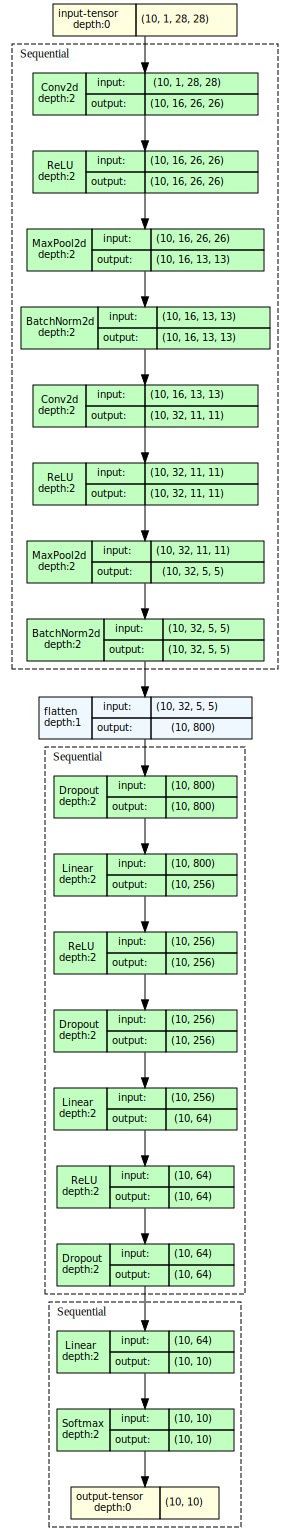

In [ ]:
x = torch.zeros(10, 1, 28, 28) #torch.zeros(10, 1, 28, 28), 10 is the batch size
y = torch.zeros(10)
dot = draw_graph(model, input_data=x, expand_nested=True, graph_name='CNN', device='cpu')
dot.resize_graph(1.5)
dot.visual_graph


### <font color='gold'>**Function `evaluate`**</font>

Let's define a *utility function* to evaluate the performance of a model on a dataset.
The function returns:

- <u>Average loss</u> on the dataset
- <u>Accuracy</u> of the prediction (assuming the class with the highest probability is selected)
- <u>Info</u>: a dictionary containing data that will be useful for studying the training process:
  - Embedding (vector representation before the output layer) of the examples
  -Probability distribution returned by the model
  - Model prediction (most probable class)
  -Targets (true labels)

In [ ]:
def evaluate(model, dataset, args, no_loading_bar=True):
  dataloader = DataLoader(dataset, batch_size=args.batch_size, num_workers=2)

  tot_loss = 0
  n_correct = 0
  embeddings, preds, target, probs = [], [], [], []

  model.eval()

  with torch.no_grad():
    for (X, y) in tqdm(dataloader, disable=no_loading_bar):
      X, y = X.to(args.device), y.to(args.device)

      # Calculation of the probabilities of class membership
      prob = model(X)

      # Calculation of the predictions: class with the highest probability
      pred = prob.argmax(-1)

      # Calculation of the average loss on the batch (can be Mean Squared Error, Cross Entropy, or other...)
      loss = args.loss_fn(prob, y)

      n_correct += sum(pred == y)
      tot_loss += loss.item() * X.shape[0]

      embeddings.append(model.embeddings)
      probs.append(prob)
      preds.append(pred)
      target.append(y)

  info = {
    'embeddings': torch.cat(embeddings),
    'prob': torch.cat(probs),
    'preds': torch.cat(preds),
    'target': torch.cat(target)
  }
  return tot_loss / len(dataset), n_correct / len(dataset), info



### <font color='gold'>**Function  `train`**</font>

Let's define the actual training function. The function implements an algorithm of [Early stopping](https://en.wikipedia.org/wiki/Early_stopping), a regularization technique that allows training a model to avoid overfitting. This algorithm is based on the concept of *patience*, which is the number of epochs that can pass without the validation loss decreasing before training ends.

In other words, early stopping works as follows:


1. Consider a parameter `patience`, and a variable `count` (initially set to 0).
2. At the end of each epoch, calculate the validation loss.
3. If the validation loss is <font color='green'>less than</font> that of the previous epoch, continue training for the next epoch.
4. Otherwise, if the loss is <font color='red'>greater than</font> the previous epoch, update count as follows: count = count + 1.
5. If `count == patience` (the level of *patience* has been reached), then terminate the training.
**Note 1:** <font color="aqua">Why use patience, and not stop when the validation loss decreases?</font>


- <u>Overfitting</u> occurs when the training loss continues to decrease but the validation loss starts to increase.
- - However, it may not be a good idea to stop training as soon as a lower validation loss is encountered compared to the previous epoch.
In fact, it often happens that in some subsequent epoch, the loss decreases again.

**Note 2:** <font color='aqua'>Keep track of the best checkpoint (the state of the network weights)</font>

- It is a good practice to keep track of the network weights whenever the validation loss improves.
- This way, at the end of training, we can obtain the network with the <u>minimum validation loss</u>.


In [ ]:
def train(model, train_dataset, val_dataset, args):
  optimizer = args.optim_class(model.parameters(), lr=args.lr)
  dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)#shuffle: cambia ordine

  train_losses, val_losses = dict(), dict()
  step = -1
  count = 0
  best_val_loss = float('inf')
  best_model = None

  ### START OF TRAINING
  for epoch in range(args.n_epochs):

    tot_loss = 0
    num_examples = 0
    n_correct = 0

    loading_bar = tqdm(dataloader) #tqdm is a library in Python that provides progress bars for loops and iterables.
    model.train() #sets the model to training mode (instead of evaluation mode). Hence dropout operates,batch norm calculates
                  #the statistics.

    ### EPOCH OF TRAINING
    for (X, y) in loading_bar:
      X, y = X.to(args.device), y.to(args.device)

      # classes probability
      prob = model(X)

      # average loss on batch
      loss = args.loss_fn(prob, y)

      # Gradient zeroing, backpropagation, and optimization
      # Gradient Zeroing: Before performing a new optimization step, the gradients from the previous step need to be cleared.
      # This is done to prevent accumulation of gradients across multiple iterations, which could lead to incorrect updates.
      optimizer.zero_grad()

      #Backpropagation: This is the process of computing the gradient of the loss function with respect to each weight by the chain rule,
      #allowing us to propagate the error backward through the network.
      loss.backward()

      #After calculating the gradients, an optimizer updates the weights of the model based on these gradients.
      optimizer.step()
      step += 1

      # log step
      tot_loss += loss.item() * X.shape[0]
      num_examples += X.shape[0]
      running_loss = tot_loss / num_examples
      train_losses[step] = running_loss

      pred = prob.argmax(-1) #we want to find the index of the maximum element along the last dimension of the tensor. In this case, the last dimension represents the different classes.
      n_correct += sum(pred == y)

      loading_bar.set_description(f'Epoch {epoch+1:<3d} [Loss: {running_loss:.4f}]')
    ### END OF EPOCH OF TRANING

    train_accuracy = n_correct / len(train_dataset)
    val_loss, val_accuracy, _ = evaluate(model, val_dataset, args)
    val_losses[step] = val_loss

    print('-'*80)
    print(f'Train accuracy: {train_accuracy:.2%}')
    print(f'Val accuracy:   {val_accuracy:.2%}')
    print(f'Val loss:       {val_loss:.4f}')

    # early stopping
    if val_loss > best_val_loss:
      count += 1
      print(f'===> Patience {count:>3d}/{args.patience:<3d}')
      if count == args.patience:
        break
    else:
      count = 0
      best_val_loss = val_loss
      best_model = model.state_dict()

    print()
  ### END OF TRAINING

  model.load_state_dict(best_model)

  return train_losses, val_losses


### <font color='gold'>**Definition of Training Hyperparameters**</font>

Let's define the training hyperparameters. We use **Cross-Entropy Loss**, which is often better than *Mean-Squared Error* in classification problems:
$$
H_p(q) = - \sum_{c=1}^Cq(y_c) \log p(y_c)
$$

As the optimization algorithm, we use  *Adam*, which is often better than  *Stochastic Gradient Descent*.

We save the weights of the network to perform comparisons with those at the end of training.


In [ ]:
args = SimpleNamespace(
    loss_fn = nn.CrossEntropyLoss(),
    optim_class = torch.optim.Adam, #possible alternative = SGD
    batch_size = 1024,
    lr = 0.0005,
    n_epochs = 20,
    patience = 20,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    seed = 42
)

torch.manual_seed(args.seed)
model = CNN().to(args.device)

torch.save(model.state_dict(), 'model_before_train.pt')

### <font color='gold'>**Training!**</font> 🧠

We are ready to train the network. <u>**Note:**</u> on **Colab con runtime T4 GPU**, the training takes about <font color='teal'>2</font> minutes.

We save the model weights after training, along with the training and validation loss.


In [ ]:
#ct
print(args.device)
print(torch.cuda.is_available())


In [ ]:
train_losses, val_losses = train(model, train_dataset, val_dataset, args)

torch.save({'train': train_losses, 'val': val_losses}, 'losses.pt')
torch.save(model.state_dict(), 'model_after_train.pt')



### 💡<font color='lightblue'>**In-depth: Visualization of the representations learned by the network**</font>

We can visualize how the network has learned to represent each example internally.

In defining the `forward` function of the network, we programmed the saving of the internal representation of the network before the output layer, as shown here:


In [ ]:
print(model.__repr__().replace('(out)', '\033[96m>>>>>>>>>>>>>>> SAVE EMBEDDINGS  (INPUT TO OUTPUT LEVEL) <<<<<<<<<<<<<<<\033[0m\n  (out)'))

Let's visualize with PCA the vector representations of each example taken before the portion of the network called `out` (which returns the probabilities of belonging to a class).

In [ ]:
model.load_state_dict(torch.load('model_before_train.pt'))
_, _, info = evaluate(model, train_dataset, args, no_loading_bar=False)
plot_dataset_visualization(info['embeddings'].cpu(), info['target'].cpu(), PCA(2), 'Internal Representation before training')
plt.show()
print('\n')

model.load_state_dict(torch.load('model_after_train.pt'))
_, _, info = evaluate(model, train_dataset, args, no_loading_bar=False)
plot_dataset_visualization(info['embeddings'].cpu(), info['target'].cpu(), PCA(2), 'Internal Representation  $\mathbf{after}$ training')


### <font color='gold'>**Visualization of Training Loss and Validation Loss**</font>

Now we can visualize the graph of training loss and validation loss. We overlay the two curves to see how they progress during training. We also visualize the curves on a logarithmic scale (over the number of *steps*).

In [ ]:
losses_dict = torch.load('losses.pt')
train_losses, val_losses = losses_dict['train'], losses_dict['val']

plt.subplots(1,2, figsize=(16,4))
for i, (func, title) in enumerate([(plt.plot, 'Loss'), (plt.semilogx, 'Loss (log scale)')]):
  plt.subplot(1,2,i+1)
  func(list(train_losses.keys()), list(train_losses.values()), label='Train loss')
  func(list(val_losses.keys()), list(val_losses.values()), label='Val loss')
  idx = np.argmin(list(val_losses.values()))
  plt.axvline(list(val_losses.keys())[idx], color='red', label='Best val loss', linestyle='dashed')
  plt.legend()
  plt.title(title)
  plt.subplots_adjust(wspace=0.1)
  plt.xlabel('step')
  plt.grid('on', 'both')


### <font color='gold'>**Model Testing**</font>

Once training is complete, we can test the performance of our model. First, let's calculate the accuracy of the predictions.

In [ ]:
_, test_accuracy, info = evaluate(model, test_dataset, args)
print(f'Test accuracy: {test_accuracy:.4f}')

Now let's visualize the confusion matrix to observe the most common errors made by the model.

In [ ]:
target, preds = info['target'].cpu(), info['preds'].cpu()
ConfusionMatrixDisplay.from_predictions(target, preds)
plt.gca().set_yticklabels(target_names)
plt.gca().set_xticklabels(target_names)
plt.xticks(rotation = 45)
plt.title('Confusion matrix')
plt.show()


### 💡<font color='lightblue'>**In-depth: Error per Class  </font>

It can be observed that examples of the *Shirt* class are often misclassified.

In [ ]:
print('Percentage of misclassified examples\n' + '-'*100)
for y in range(len(target_names)):
  misclassified_y = (preds != target) & (target == y)
  all_y = target == y

  print(f'{target_names[y]:>12}: {sum(misclassified_y)/sum(all_y):.2%}')



## Conclusion
Solving a Machine Learning problem almost always requires *trial and error*, especially in the choice of hyperparameters.

If you're interested, you can try to improve the model's performance. <font color='gold'><u>**What to modify?**</u></font>

1) In the current implementation:
* How many convolutional levels there are, what are their characteristics (kernedl size, stride, channels).
* How many Max Pooling layers? (with what characteristics)?
* How many Fully Connected Layers?

2) Vary the learning hyperparameters:
* the maximum number of epochs
* the number of epochs to "patience"
* the size of mini-batches
* learning rate

3) [IF YOU HAVE TIME] With the help of the  [PyTorch documentation](https://pytorch.org/docs/stable/nn.html), try varying in the model some of the following aspects (by paying attention to dimension adjustements that you might need to do]:
* parameters of convolutional and pooling layers
* number of channels
* kernel size
* padding
* stride
* the number of *fully connected* layers (`Linear`) and, in each, the number of neurons
* the presence of `Dropout` layers (potentially modifying the *dropout rate*)
* the presence of `BatchNorm2d` layers





**With this dataset and using a relatively simple convolutional network, the accuracy can easily exceed 90%.**
